# Finding the winning strategy in a red-color-win card game

Would you like to win a bit of money? Let’s wager on a card game for minor stakes. In front of you is a shuffled deck of cards. All 52 cards lie face down. Half the cards are red, and half are black. I will proceed to flip over the cards one by one. If the last card I flip over is red, you’ll win a dollar. Otherwise, you’ll lose a dollar.

Here’s the twist: you can ask me to halt the game at any time. Once you say “Halt,” I will flip over the next card and end the game. That next card will serve as the final card. You will win a dollar if it’s red.

We can play the game as many times as you like. The deck will be reshuffled every time. After each round, we’ll exchange money. What is your best approach to winning this game?

<aside>
📌 To address the problem at hand, we will need to know how to 1) Compute the probabilities of observable events using sample space analysis, 2) Plot the probabilities of events across a range of interval values, 3) Simulate random processes, such as coin flips and card shuffling, using Python, 4) Evaluate our confidence in decisions drawn from simulations using confidence interval analysis.

</aside>

Our goal is to discover a strategy that best predicts a red card in the deck. We will do so by

1. Developing multiple strategies for predicting red cards in a randomly shuffled deck.
2. Applying each strategy across multiple simulations to compute its probability of success within a high confidence interval. If these computations prove to be intractable, we will instead focus on those strategies that perform best across a 10-card sample space.
3. Returning the simplest strategy associated with the highest probability of success.

In [ ]:
import numpy as np
import itertools
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
np.random.seed(0)

We start by creating a deck holding 26 red cards and 26 black cards. Black cards are represented by 0s, and red cards are represented by 1s. We proceed to shuffle the deck.

In [ ]:
red_cards = 26 * [1]
black_cards = 26 * [0]
unshuffled_deck = red_cards + black_cards
total_cards = 52
total_red_cards = 26
remaining_red_cards = 26
shuffled_deck = np.random.permutation(unshuffled_deck)

Now we iteratively flip over the cards in the deck, stopping when the next card is more likely to be red. Then we flip over the next card. We win if that card is red.

How do we decide when we should stop? One simple strategy is to **terminate the game when the number of red cards remaining in the deck is greater than the number of black cards remaining in the deck**. Let’s execute that strategy on the shuffled deck.

In [ ]:
for i, card in enumerate(shuffled_deck[:-1]):
    remaining_red_cards -= card
    remaining_total_cards = 52 - i
    if remaining_red_cards / remaining_total_cards > 0.5:
        break

print(f"Stopping the game at index {i}.")
final_card = shuffled_deck[i + 1]
color = 'red' if final_card else 0
print(f"The next card in the deck is {'red' if final_card else 'black'}.")
print(f"We have {'won' if final_card else 'lost'}!")

Stopping the game at index 1.
The next card in the deck is red.
We have won!


The strategy yielded a win on our very first try. Our strategy halts when the fraction of remaining red cards is greater than half of the remaining total cards. We can generalize that fraction to equal a min_red_fraction parameter, thus halting when the red card ratio is greater than the inputted parameter value. This generalized strategy is implemented next with min_red_fraction preset to 0.5.

In [ ]:
def execute_strategy(min_fraction_red=0.5, shuffled_deck=None,
                     return_index=False):
    if shuffled_deck is None:

        shuffled_deck = np.random.permutation(unshuffled_deck)
    remaining_red_cards = total_red_cards

    for i, card in enumerate(shuffled_deck[:-1]):
        remaining_red_cards -= card
        fraction_red_cards = remaining_red_cards / (total_cards - i)
        if fraction_red_cards > min_fraction_red:
            break

    return (i+1, shuffled_deck[i+1]) if return_index else shuffled_deck[i+1]

Let’s apply our basic strategy to a series of 1,000 random shuffles. The total fraction of 1s in observations corresponds to the observed fraction of red cards and therefore to the fraction of wins. We can compute this fraction by summing the 1s in observations and dividing by the array size. As an aside, that computation can also be carried out by calling observations.mean().

In [ ]:
observations = np.array([execute_strategy() for _ in range(1000)])
frequency_wins = observations.sum() / 1000
assert frequency_wins == observations.mean()
print(f"The frequency of wins is {frequency_wins}")

The frequency of wins is 0.523


In [ ]:
dollars_won = frequency_wins * 1000
dollars_lost = (1 - frequency_wins) * 1000
total_profit = dollars_won - dollars_lost
print(f"Total profit is ${total_profit}")

Total profit is $46.0


The strategy worked well for a sample size of 1,000 shuffles. We now plot the strategy’s win-frequency convergence over a series of sample sizes ranging from 1 through 1,000.

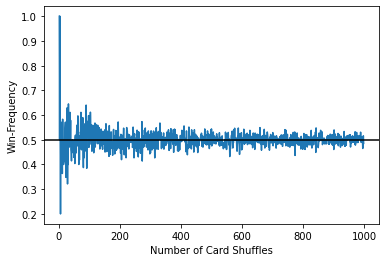

The win-frequency for 10,000 shuffles is 0.4854854854854855


In [ ]:
def repeat_game(number_repeats):
    observations = np.array([execute_strategy()
                             for _ in range(number_repeats)])
    return observations.mean()

frequencies = []
for i in range(1, 1000):
    frequencies.append(repeat_game(i))

plt.plot(list(range(1, 1000)), frequencies)
plt.axhline(.5, color='k')
plt.xlabel('Number of Card Shuffles')
plt.ylabel('Win-Frequency')
plt.show()
print(f"The win-frequency for 10,000 shuffles is {frequencies[-1]}")

In [ ]:
def compute_high_confidence_interval(likelihoods, bin_width):
    peak_index = likelihoods.argmax()
    area = likelihoods[peak_index] * bin_width
    start_index, end_index = peak_index, peak_index + 1
    while area < 0.95:
        if start_index > 0:
            start_index -= 1
        if end_index < likelihoods.size - 1:
            end_index += 1

        area = likelihoods[start_index: end_index + 1].sum() * bin_width

    range_start, range_end = bin_edges[start_index], bin_edges[end_index]
    range_string = f"{range_start:.6f} - {range_end:.6f}"
    print((f"The frequency range {range_string} represents a "
           f"{100 * area:.2f}% confidence interval"))
    return start_index, end_index

  0%|          | 0/300 [00:00<?, ?it/s]

The frequency range 0.488771 - 0.512264 represents a 97.00% confidence interval


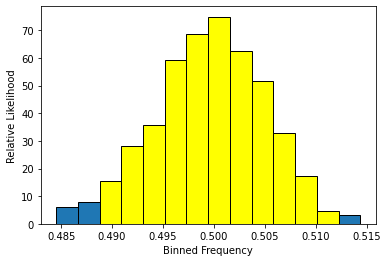

In [ ]:
frequency_array = np.array([repeat_game(10000) for _ in tqdm(range(300))])

likelihoods, bin_edges, patches = plt.hist(frequency_array, bins='auto',
                                           edgecolor='black', density=True)
bin_width = bin_edges[1] - bin_edges[0]

start_index, end_index = compute_high_confidence_interval(likelihoods, bin_width)

for i in range(start_index, end_index):
     patches[i].set_facecolor('yellow')
plt.xlabel('Binned Frequency')
plt.ylabel('Relative Likelihood')
plt.show()

We are quite confident that the actual probability lies somewhere between 0.488 and 0.509. However, we still don’t know whether that probability is above 0.5 or below 0.5. This is a problem: even a minor misinterpretation of the true probability could cause us to lose money.

Imagine that the true probability is 0.5001. If we apply our strategy to 1 billion shuffles, we should expect to win \$200,000. Now suppose we were wrong, and the actual probability is 0.4999. In this scenario, we will lose $200,000. A tiny error over the fourth decimal space could cost us hundreds of thousands of dollars.

We must be absolutely certain that the true probability lies above 0.5. Thus, we must narrow the 95% confidence interval by increasing the sample size at the expense of running time. The following code samples 50,000 shuffles over 3,000 iterations. It takes approximately an hour to run.

Surprisingly, our basic strategy yields a win only 50% of the time. This is no better than selecting the first card at random! Maybe our min_red_fraction parameter was insufficiently low. We can find out by sampling all the two-decimal min_red_fraction values between 0.50 and 1.0. The following code computes the win probabilities over a range of min_red_fraction values and returns the minimum and maximum probabilities.

In [ ]:
def compute_event_probability(event_condition, generic_sample_space):
    event = get_event(event_condition, generic_sample_space)
    if type(generic_sample_space) == type(set()):
        return len(event) / len(generic_sample_space)

    event_size = sum(generic_sample_space[outcome]
                     for outcome in event)
    return event_size / sum(generic_sample_space.values())

In [ ]:
def get_event(event_condition, sample_space):
    return set([outcome for outcome in sample_space
                if event_condition(outcome)])

In [ ]:
red_cards = 26 * [1]
black_cards = 26 * [0]
unshuffled_deck = red_cards + black_cards

sample_space = set(itertools.permutations(unshuffled_deck))
print(f"Sample space for a 10-card deck contains {len(sample_space)} elements")

In [ ]:
def scan_strategies():
    fractions = [value / 100 for value in range(50, 100)]
    probabilities = []
    for frac in fractions:
        win_condition = lambda x: execute_strategy(frac,
                                                   shuffled_deck=np.array(x))
        probabilities.append(compute_event_probability(win_condition,
                                                       sample_space))
    return probabilities

probabilities = scan_strategies()
print(f"Lowest probability of win is {min(probabilities)}")
print(f"Highest probability of win is {max(probabilities)}")

Both the lowest and highest probabilities are equal to 0.5! None of our strategies have outperformed a random card choice. Perhaps adjusting the deck size will yield some improvement. Let’s analyze the sample spaces of decks containing two, four, six, and eight cards. We apply all strategies to each sample space and return their probabilities of winning. Then we search for a probability that isn’t equal to 0.5.

In [ ]:
for total_cards in [2, 4, 6, 8]:
    total_red_cards = int(total_cards / 2)
    total_black_cards = total_red_cards
    unshuffled_deck = [1] * total_red_cards + [0] * total_black_cards

    sample_space = set(itertools.permutations(unshuffled_deck))
    probabilities = scan_strategies()
    if all(prob == 0.5 for prob in probabilities):
        print(f"No winning strategy found for deck of size {total_cards}")
    else:
        print(f"Winning strategy found for deck of size {total_cards}")

No winning strategy found for deck of size 2
No winning strategy found for deck of size 4
No winning strategy found for deck of size 6
No winning strategy found for deck of size 8


All of the strategies yield a probability of 0.5 across the small decks. Each time we increase the deck size, we add two additional cards to the deck, but this fails to improve performance. A strategy that fails on a 2-card deck continues to fail on a 4-card deck, and a strategy that fails on an 8-card deck continues to fail on a 10-card deck. We can extrapolate this logic even further. A strategy that fails on a 10-card deck will probably fail on a 12-card deck, and thus on a 14-card deck and a 16-card deck. Eventually, it will fail on a 52-card deck. Qualitatively, this inductive argument makes sense. Mathematically, it can be proven to be true. Right now, we don’t need to concern ourselves with the math. What’s important is that our instincts have been proven wrong. Our strategies don’t work on a 10-card deck, and we have little reason to believe they will work on a 52-card deck. Why do the strategies fail?

Intuitively, our initial strategy made sense: if there are more red cards than black cards in the deck, then we are more likely to pick a red card from the deck. However, we failed to take into account those scenarios when the red cards never outnumber the black cards. For instance, suppose the first 26 cards are red and the remainder are black. In these circumstances, our strategies will fail to halt, and we will lose. Also, let’s consider a shuffled deck where the first 25 cards are red, the next 26 cards are black, and the final card is red. Here, our strategy will fail to halt, but we will still win. It seems each strategy can lead to one of four scenarios:
- Strategy halts and the next card is red. We win.
- Strategy halts and the next card is black. We lose.
- Strategy doesn’t halt and the final card is red. We win.
- Strategy doesn’t halt and the final card is black. We lose.

Let’s sample how frequently the four scenarios occur across 50,000 card shuffles. We record these frequencies over our range of two-digit min_red_fraction values. We then plot each min_red_fraction value against the occurrence rates observed from the four scenarios.

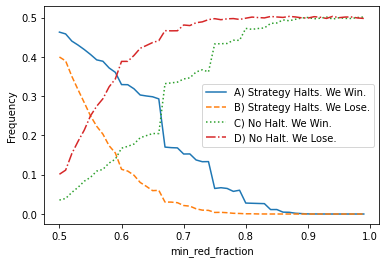

In [ ]:
np.random.seed(0)
total_cards = 52
total_red_cards = 26
unshuffled_deck = red_cards + black_cards

def repeat_game_detailed(number_repeats, min_red_fraction):

    observations = [execute_strategy(min_red_fraction, return_index=True)
                    for _ in range(num_repeats)]
    successes = [index for index, card, in observations if card == 1]
    halt_success = len([index for index in successes if index != 51])
    no_halt_success = len(successes) - halt_success

    failures = [index for index, card, in observations if card == 0]
    halt_failure = len([index for index in failures if index != 51])
    no_halt_failure = len(failures) - halt_failure
    result = [halt_success, halt_failure, no_halt_success, no_halt_failure]
    return [r / number_repeats for r in result]

fractions = [value / 100 for value in range(50, 100)]
num_repeats = 50000
result_types = [[], [], [], []]

for fraction in tqdm(fractions, total=len(fractions)):
    result = repeat_game_detailed(num_repeats, fraction)
    for i in range(4):
        result_types[i].append(result[i])

plt.plot(fractions, result_types[0],
         label='A) Strategy Halts. We Win.')
plt.plot(fractions, result_types[1], linestyle='--',
         label='B) Strategy Halts. We Lose.')
plt.plot(fractions, result_types[2], linestyle=':',
         label='C) No Halt. We Win.')
plt.plot(fractions, result_types[3], linestyle='-.',
         label='D) No Halt. We Lose.')
plt.xlabel('min_red_fraction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Let’s examine the plot at the min_red_fraction value of 0.5. Here, scenario A (Strategy Halts. We Win.) is the most common outcome, with a frequency of approximately 0.49. Meanwhile, a halt leads to a loss approximately 46% of the time (strategy B). So why do we maintain a 50% chance of winning the game? Well, in 1% of the cases, our strategy fails to halt, but we still win (scenario C). The strategy’s weakness is counterbalanced by random chance.

Within the plot, as the min_red_fraction goes up, the frequency of scenario A goes down. The more conservative we are, the less likely we are to stop the game prematurely and yield a win. Meanwhile, the success rate of scenario C increases. The more conservative we are, the higher the likelihood of reaching the final card and winning by chance.

As min_red_fraction increases, both scenario A and scenario C converge to a frequency of 0.25. Thus the probability of a win remains at 50%. Sometimes our strategy halts, and we do win. Other times, the strategy halts, and we still lose. Any advantage that each strategy offers is automatically wiped out by these losses. However, we occasionally get lucky: our strategy fails to halt, yet we win the game. These lucky wins amend our losses, and our probability of winning stays the same. No matter what we do, our likelihood of winning remains fifty-fifty. Therefore, the optimal strategy we can offer is to pick the first card in the shuffled deck.